In [1]:
import numpy as np
from matplotlib import pyplot as plt
import george
from george.kernels import ExpSquaredKernel
from sklearn.gaussian_process import GaussianProcess

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

%matplotlib inline

Want to figure out where George.ExpSquaredKernel and sklearn.gaussian_process.GaussianProcess intersect

In [2]:
# define a squared exponential covariance function
def squared_exponential(x1, x2, h):
    return np.exp(-0.5 * (x1 - x2) ** 2 / h ** 2)

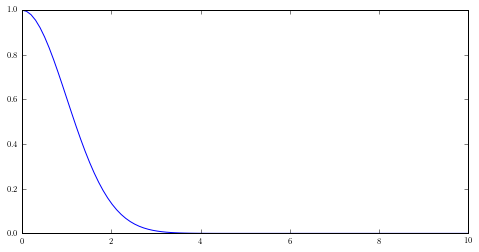

In [3]:
x = np.linspace(0, 10, 100)
h = 1.0
y = squared_exponential(x[0], x, h)

fig = plt.figure(figsize=(8,4))
plt.plot(x, y, color="b")
plt.show()

The above is what the result of a squared exponential looks like just straight up mathematically. Let's try the same thing with george

In [4]:
kernel = ExpSquaredKernel(metric=1.0)
gp_george = george.GP(kernel)
gp_george.compute(x, yerr=0.1)
y_george = gp_george.kernel.value(x[:, np.newaxis])

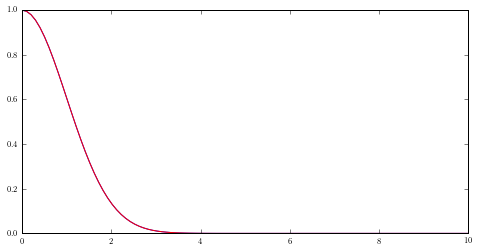

In [5]:
fig = plt.figure(figsize=(8,4))
plt.plot(x, y, color="b")
plt.plot(x, y_george[0,:], color="r")

plt.show()

W00T! It matches up one-to-one! Alright then, lets test out what this "metric" parameter corresponds to in the actual squared exponential kernel. There's a couple things it could be:
- $h$
- $h^2$
- $h^2/2$
- $1/h$
- $1/h^2$
- $2/h^2$

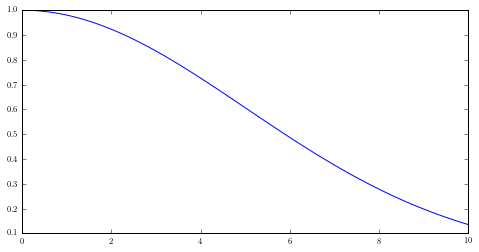

In [6]:
h = 5.0
y = squared_exponential(x[0], x, h)

fig = plt.figure(figsize=(8,4))
plt.plot(x, y, color="b")
plt.show()

In [7]:
# testing: metric = h
kernel = ExpSquaredKernel(metric=h)
gp_george1 = george.GP(kernel)
gp_george1.compute(x, yerr=0.1)
y_george1 = gp_george1.kernel.value(x[:, np.newaxis])

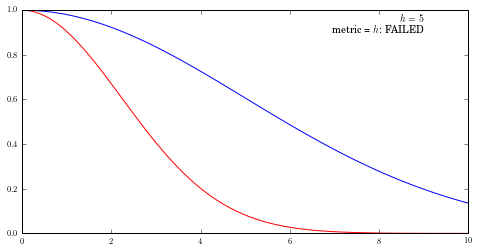

In [8]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
ax.plot(x, y, color="b")
ax.plot(x, y_george1[0,:], color="r")
ax.text(0.9, 0.9, "$h = 5$\nmetric = $h$: FAILED", transform=ax.transAxes, horizontalalignment="right")

plt.show()

In [9]:
# testing: metric = h^2
kernel = ExpSquaredKernel(metric=h**2)
gp_george2 = george.GP(kernel)
gp_george2.compute(x, yerr=0.1)
y_george2 = gp_george2.kernel.value(x[:, np.newaxis])

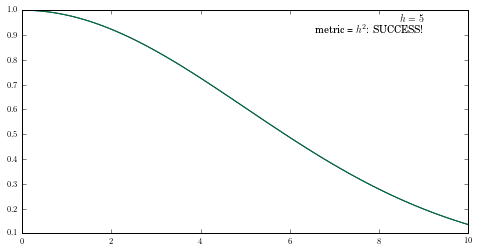

In [10]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
ax.plot(x, y, color="b")
ax.plot(x, y_george2[0,:], color="g")
ax.text(0.9, 0.9, "$h=5$\nmetric = $h^2$: SUCCESS!", transform=ax.transAxes, horizontalalignment="right")

plt.show()

Ok, so for george, metric $= h^2$. Good to know. What about for scikit-learn? What does theta correspond to? Let's compare it to what we already know from George.

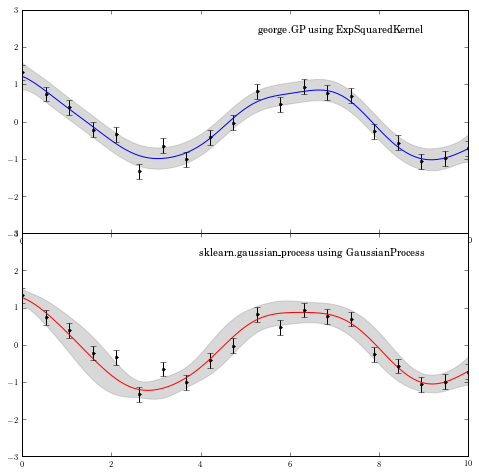

In [11]:
np.random.seed(1)
xtest = np.linspace(0, 10, 20)
ytest = np.cos(xtest)
dy = 0.2
ytest = np.random.normal(ytest, dy)
x = np.linspace(0, 10, 100)

h = 1.0
gp_george2 = george.GP(ExpSquaredKernel(h**2))
gp_george2.compute(xtest, yerr=dy)
f_george2, cov2 = gp_george2.predict(ytest, x)
f_george_err2 = np.sqrt(np.diag(cov2))

gp_sk1 = GaussianProcess(corr='squared_exponential', theta0=0.5, nugget=(dy/ytest)**2,
                      random_state=0, normalize=False)
gp_sk1.fit(xtest[:, None], ytest)
f_sk1, MSE_sk1 = gp_sk1.predict(x[:, None], eval_MSE=True)
f_sk1_err = np.sqrt(MSE_sk1)

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0)
ax = fig.add_subplot(211)
ax.plot(x, f_george2, "-", color="b")
ax.fill_between(x, f_george2 - 2 * f_george_err2, f_george2 + 2 * f_george_err2, color='gray', alpha=0.3)
ax.errorbar(xtest, ytest, dy, fmt='.k', ms=6)
ax.text(0.9, 0.9, "george.GP using ExpSquaredKernel", transform=ax.transAxes, horizontalalignment="right")
ax.set_ylim(-3,3)

ax = fig.add_subplot(212)
ax.plot(x, f_sk1, "-", color="r")
ax.fill_between(x, f_sk1 - 2 * f_sk1_err, f_sk1 + 2 * f_sk1_err, color='gray', alpha=0.3)
ax.errorbar(xtest, ytest, dy, fmt='.k', ms=6)
ax.text(0.9, 0.9, "sklearn.gaussian\_process using GaussianProcess", transform=ax.transAxes, horizontalalignment="right")
ax.set_ylim(-3,3)

plt.show()

Note that these only match because GaussianProcess from scikit-learn's noramlize flag is set to False. When set to True, the curve is smoothed, but does not match the output from george.

Alright, let's try to redo those plots from Ch. 8 here then, showing comparisons between using george and using scikit-learn

/Users/Nick/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: RuntimeWarning: covariance is not positive-semidefinite.


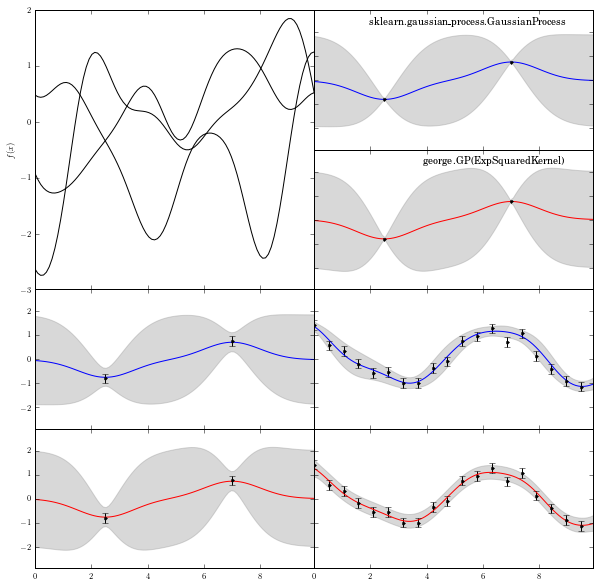

In [12]:
# draw samples from the unconstrained covariance
np.random.seed(1)
x = np.linspace(0, 10, 100)
h = 1.0

mu = np.zeros(len(x))
C = squared_exponential(x, x[:, None], h)
draws = np.random.multivariate_normal(mu, C, 3)

#------------------------------------------------------------
# Constrain the mean and covariance with two points
x1 = np.array([2.5, 7])
y1 = np.cos(x1)
gp_sk1 = GaussianProcess(corr='squared_exponential', theta0=0.5,
                      random_state=0, normalize=False)
gp_sk1.fit(x1[:, None], y1)
f_sk1, MSE_sk1 = gp_sk1.predict(x[:, None], eval_MSE=True)
fsk1_err = np.sqrt(MSE_sk1)

gp_george1 = george.GP(ExpSquaredKernel(h**2))
gp_george1.compute(x1)
f_george1, cov1 = gp_george1.predict(y1, x)
f_george_err1 = np.sqrt(np.diag(cov1))

#------------------------------------------------------------
# Add errors to the constrained function
dy2 = 0.2
gp_sk2 = GaussianProcess(corr='squared_exponential', theta0=0.5,
                      random_state=0, nugget=(dy2/y1)**2, normalize=False)
gp_sk2.fit(x1[:, None], y1)
f_sk2, MSE_sk2 = gp_sk2.predict(x[:, None], eval_MSE=True)
fsk2_err = np.sqrt(MSE_sk2)

gp_george2 = george.GP(ExpSquaredKernel(h**2))
gp_george2.compute(x1, dy2)
f_george2, cov2 = gp_george2.predict(y1, x)
f_george_err2 = np.sqrt(np.diag(cov2))

#------------------------------------------------------------
# Add errors to the constrained function
x3 = np.linspace(0, 10, 20)
y3 = np.cos(x3)
dy3 = 0.2
y3 = np.random.normal(y3, dy3)
gp_sk3 = GaussianProcess(corr='squared_exponential', theta0=0.5,
                      random_state=0, nugget=(dy3/y3)**2, normalize=False)
gp_sk3.fit(x3[:, None], y3)
f_sk3, MSE_sk3 = gp_sk3.predict(x[:, None], eval_MSE=True)
fsk3_err = np.sqrt(MSE_sk3)

gp_george3 = george.GP(ExpSquaredKernel(h**2))
gp_george3.compute(x3, dy3)
f_george3, cov3 = gp_george3.predict(y3, x)
f_george_err3 = np.sqrt(np.diag(cov3))

#------------------------------------------------------------
# Plot the diagrams
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0, wspace=0)

# first: plot a selection of unconstrained functions
ax = fig.add_subplot(221)
ax.plot(x, draws.T, "-k")
ax.set_ylabel('$f(x)$')
ax.set_xlim(0, 9.9)
ax.set_xticklabels([])

# second: plot the function constrained at 2 points
ax = fig.add_subplot(422)
ax.plot(x, f_sk1, "-", color="blue")
ax.fill_between(x, f_sk1 - 2*fsk1_err, f_sk1 + 2*fsk1_err, color="gray", alpha=0.3)
ax.text(0.9, 0.9, "sklearn.gaussian\_process.GaussianProcess", transform=ax.transAxes, horizontalalignment="right")
ax.plot(x1, y1, ".k", ms=6)
ax.set_ylim(-2.9, 2.9)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlim(0, 9.9)

ax = fig.add_subplot(424)
ax.plot(x, f_george1, "-", color="red")
ax.fill_between(x, f_george1 - 2*f_george_err1, f_george1 + 2*f_george_err1, color="gray", alpha=0.3)
ax.text(0.9, 0.9, "george.GP(ExpSquaredKernel)", transform=ax.transAxes, horizontalalignment="right")
ax.plot(x1, y1, ".k", ms=6)
ax.set_ylim(-2.9, 2.9)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlim(0, 9.9)

# third: plot the constrained function with errors
ax = fig.add_subplot(425)
ax.plot(x, f_sk2, "-", color="blue")
ax.fill_between(x, f_sk2 - 2*fsk2_err, f_sk2 + 2*fsk2_err, color="gray", alpha=0.3)
ax.errorbar(x1, y1, dy2, fmt =".k", ms=6)
ax.set_ylim(-2.9, 2.9)
ax.set_xticklabels([])
ax.set_xlim(0, 9.9)

ax = fig.add_subplot(427)
ax.plot(x, f_george2, "-", color="red")
ax.fill_between(x, f_george2 - 2*f_george_err2, f_george2 + 2*f_george_err2, color="gray", alpha=0.3)
ax.errorbar(x1, y1, dy2, fmt=".k", ms=6)
ax.set_ylim(-2.9, 2.9)
ax.set_xlim(0, 9.9)

# fourth: plot the mean and covariance with many noisy points
ax = fig.add_subplot(426)
ax.plot(x, f_sk3, "-", color="blue")
ax.fill_between(x, f_sk3 - 2*fsk3_err, f_sk3 + 2*fsk3_err, color="gray", alpha=0.3)
ax.errorbar(x3, y3, dy3, fmt =".k", ms=6)
ax.set_ylim(-2.9, 2.9)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlim(0, 9.9)

ax = fig.add_subplot(428)
ax.plot(x, f_george3, "-", color="red")
ax.fill_between(x, f_george3 - 2*f_george_err3, f_george3 + 2*f_george_err3, color="gray", alpha=0.3)
ax.errorbar(x3, y3, dy3, fmt=".k", ms=6)
ax.set_ylim(-2.9, 2.9)
ax.set_yticklabels([])
ax.set_xlim(0, 9.9)

plt.show()